In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime,timedelta
from copy import deepcopy as dc


In [36]:

# Download stock price data
def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.Series:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close']
ticker="AMZN"
current_date = datetime.now()
data: pd.DataFrame = yf.download(ticker,
                                 start=current_date - timedelta(days=730),
                                 end=current_date,
                                 interval="1h")
data

In [37]:

# Preprocess data and create input sequences
def preprocess_data(data: pd.Series, sequence_length: int):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]
        sequences.append((sequence, target))
    return sequences


In [38]:

# Split data into training and testing sets
def split_data(data, test_size=0.2):
    return train_test_split(data, test_size=test_size, shuffle=False)


In [39]:

class StockPredictorCNN(nn.Module):
    def __init__(self):
        super(StockPredictorCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        self.fc1 = nn.Linear(64 * 9, 50)  # 64 filters and 9 (sequence_length - kernel_size + 1)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [40]:

# Train CNN model
def train_model(X_train, y_train, epochs=50, batch_size=32):
    model = StockPredictorCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_index, (batch_X, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

              # Print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Epoch: {0}, Batch: {1}, Loss: {2:.3f}'.format(epoch + 1, batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    
    return model


In [41]:

# Evaluate model on test data
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

def get_current_price(symbol: str):
    todays_data = yf.Ticker(symbol).history(period='1d')
    return todays_data['Close'].iloc[0]


In [42]:

start_date = '2010-05-4'
end_date = '2024-06-4'
ticker = "AMZN"

current_price = get_current_price(ticker)

stock_data = download_stock_data(ticker, start_date, end_date)

sequence_length = 10
data_sequences = preprocess_data(stock_data, sequence_length)

train_data, test_data = split_data(data_sequences)

X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])

X_test = np.array([item[0] for item in test_data])
y_test = np.array([item[1] for item in test_data])

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = train_model(X_train, y_train)

mse, r2, predictions = evaluate_model(model, X_test, y_test)


[*********************100%%**********************]  1 of 1 completed


Epoch: 1, Batch: 1, Loss: 60.000
Epoch: 1, Batch: 2, Loss: 26.005
Epoch: 1, Batch: 3, Loss: 23.291
Epoch: 1, Batch: 4, Loss: 7.029
Epoch: 1, Batch: 5, Loss: 4.954
Epoch: 1, Batch: 6, Loss: 0.334
Epoch: 1, Batch: 7, Loss: 0.194
Epoch: 1, Batch: 8, Loss: 0.684
Epoch: 1, Batch: 9, Loss: 4.153
Epoch: 1, Batch: 10, Loss: 7.458
Epoch: 1, Batch: 11, Loss: 5.170
Epoch: 1, Batch: 12, Loss: 5.993
Epoch: 1, Batch: 13, Loss: 3.908
Epoch: 1, Batch: 14, Loss: 3.330
Epoch: 1, Batch: 15, Loss: 2.756
Epoch: 1, Batch: 16, Loss: 3.204
Epoch: 1, Batch: 17, Loss: 2.351
Epoch: 1, Batch: 18, Loss: 0.997
Epoch: 1, Batch: 19, Loss: 0.297
Epoch: 1, Batch: 20, Loss: 0.081
Epoch: 1, Batch: 21, Loss: 0.107
Epoch: 1, Batch: 22, Loss: 0.231
Epoch: 1, Batch: 23, Loss: 0.728
Epoch: 1, Batch: 24, Loss: 0.680
Epoch: 1, Batch: 25, Loss: 0.998
Epoch: 1, Batch: 26, Loss: 1.652
Epoch: 1, Batch: 27, Loss: 1.225
Epoch: 1, Batch: 28, Loss: 0.532
Epoch: 1, Batch: 29, Loss: 1.118
Epoch: 1, Batch: 30, Loss: 0.569
Epoch: 1, Batch:

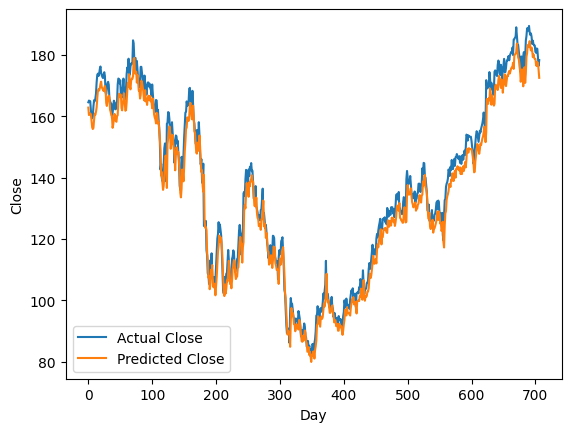

In [43]:

plt.plot(y_test, label='Actual Close')
plt.plot(predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [44]:

last_sequence = X_test[-1].reshape(1, 1, -1)
model.eval()
with torch.no_grad():
    predicted_price = model(torch.tensor(last_sequence, dtype=torch.float32)).item()

print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')

n = X_test.shape[0]
p = X_test.shape[1]

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean Squared Error on Test Data: {mse: 0.2f}')
print(f'R-squared: {r2:.4f}')
print(f'Adjusted R-squared: {adjusted_r2:.2f}')


AMZN Stock Prices

Stock Price Now:  200.00
Predicted Stock Price:  172.58
Mean Squared Error on Test Data:  22.53
R-squared: 0.9731
Adjusted R-squared: 0.97
